In [1]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt

#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    #for i in range(2,20):
    #    assert counter[i]==0
        
    return counter


def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)

In [2]:
#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)
        
print(dataset)

[{'image': [[1, 1], [1, 1]], 'category': 0}, {'image': [[0, 0], [0, 0]], 'category': 1}]


[ True  True  True ... False False False]


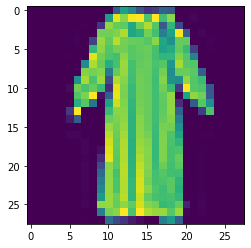

In [3]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
#you can visualize it
plt.imshow(images[1109])
print(labels)

In [4]:
#submission to part 1, you should make this into a .py file
import numpy as np
from qiskit.circuit import ClassicalRegister, QuantumCircuit, QuantumRegister
n=1
mse=0
gatecount=0



# Functions 'encode' and 'decode' are dummy.
def encode(image):
    image1=np.array(image)
    image_shape_0=image1.shape[0]
    image_shape_1=image1.shape[1]
    intensity = QuantumRegister(size=6, name="intensity")
    bits_intensity = ClassicalRegister(size=6, name="bits_intensity")
    
    
    num_qubits = int(np.ceil(np.log2(image_shape_0 * image_shape_1)))
    dim_new=int(np.sqrt(2**num_qubits))
    image_large=np.zeros((dim_new, dim_new))
    image_large[0:image_shape_0, 0:image_shape_1]=image
    qubits_index = QuantumRegister(size=num_qubits, name="pixel_indexes")
    bits_index = ClassicalRegister(size=num_qubits, name="bits_pixel_indexes")
    qc = QuantumCircuit(intensity, qubits_index, bits_intensity, bits_index)

    qc.h(qubit=qubits_index)
    qc.barrier()
    
    n = 1
    
    num_pixel = 2 ** len(qc.qregs[1])
        
    aux_bin_list = [bin(i)[2:] for i in range(num_pixel)][
                : dim_new * dim_new
            ]
    aux_len_bin_list = [len(binary_num) for binary_num in aux_bin_list]
    max_length = max(aux_len_bin_list)
    binary_list = []
    
    for bnum in aux_bin_list:
        if len(bnum) < max_length:
            new_binary = ""
            for _ in range(max_length - len(bnum)):
                new_binary += "0"
            new_binary += bnum
            binary_list.append(new_binary)
        else:
            binary_list.append(bnum)
            
    pixel_intensity = []

    
    pixels_matrix = image_large.tolist()
    
    for row in pixels_matrix:
        for entry in row:
            intensity = int(np.round(63 * entry))
            pixel_intensity.append(intensity)
            
    binary_pixel_intensity = [
            bin(p_intensity)[2:] for p_intensity in pixel_intensity
            ]    
    for k, bnum in enumerate(binary_list):

        if binary_pixel_intensity[k] != "0":
            for idx, element in enumerate(bnum[::-1]):
                if element == "0":
                    qc.x(qubit=qc.qregs[1][idx])
                    
            for idx, element in enumerate(binary_pixel_intensity[k][::-1]):
                 if element == "1":

                    qc.mct(
                        control_qubits=qc.qregs[1],
                        target_qubit=qc.qregs[0][idx],
                    )
                    
            for idx, element in enumerate(bnum[::-1]):
                        if element == "0":
                            qc.x(qubit=qc.qregs[1][idx])

    qc.barrier()
    
    

    return qc

def decode(histogram):
    keys_list = sorted(list(histogram.keys()))
    
    mylen=len(str(np.amax(keys_list)))
    intensity_strings=[]
    for key in keys_list:
        intensity_strings.append("{0:b}".format(key).zfill(mylen))
    #intensity_strings = [key.split(" ")[1] for key in keys_list]
           
    pixel_intensity = []

    for string in intensity_strings:
        intensity = 0
        for idx, char in enumerate(string):
            if char == "1":
                intensity += 2 ** (5 - idx)
        intensity = intensity / 63
        pixel_intensity.append(intensity)
    
    
       
    len2=len(pixel_intensity)
    len1=int(np.sqrt(len2))
    image_fin = np.array(pixel_intensity).reshape([len1, len1])
    
    myx, myy=[28,28]
    image=image_fin[0:myx,0:myy]
       
    return image

def run_part1(image):
    #encode image into a circuit
    
    circuit=encode(image)

    #simulate circuit
    histogram=simulate(circuit)
    

    #reconstruct the image
    image_re=decode(histogram)

    return circuit,image_re

In [5]:
#how we grade your submission

n=len(dataset)
mse=0
ms1=0
gatecount=0
gatecount1=0
    
   
for i in [1000, 1109]:
    
    circuit,image_re=run_part1(images[i])
    circuit.draw(output='mpl')
    gatecount1+=count_gates(circuit)[2]
    print("Compare")
    print(images[i])
    print(image_re)
    #calculate mse
    ms1+=image_mse(images[i],image_re)
    
print("MS1\n\n")    
print(ms1)
    
    
for data in dataset:
    #encode image into circuit
    circuit,image_re=run_part1(data['image'])
    
    #count the number of 2qubit gates used
    gatecount+=count_gates(circuit)[2]
    
    #calculate mse
    mse+=image_mse(data['image'],image_re)
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

Compare
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.00018454 0.00324491
  0.         0.         0.         0.00049212 0.00249135 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.00307574
  0.         0.         0.         0.00241446 0.00224529 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.00276817
  0.00290657 0.0014456  0.00195309 0.00333718 0.00130719 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0

In [6]:
#how we grade your submission

n=len(dataset)
mse=0
gatecount=0




for data in dataset:
    #encode image into circuit
    circuit,image_re=run_part1(data['image'])
    print ("Data")
    print(data)
    print(image_re)
    #count the number of 2qubit gates used
    gatecount+=count_gates(circuit)[2]
    
    #calculate mse
    mse+=image_mse(data['image'],image_re)
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

Data
{'image': [[1, 1], [1, 1]], 'category': 0}
[[1.         1.00793651]
 [0.75793651 1.01190476]]
Data
{'image': [[0, 0], [0, 0]], 'category': 1}
[[0.         0.50793651]
 [0.50793651 0.76190476]]
0.7111756739732931


In [7]:
#how we grade your submission

n=len(dataset)
mse=0
gatecount=0




for data in dataset:
    #encode image into circuit
    circuit,image_re=run_part1(data['image'])
    
    #count the number of 2qubit gates used
    gatecount+=count_gates(circuit)[2]
    
    #calculate mse
    mse+=image_mse(data['image'],image_re)
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

0.7111756739732931


In [8]:
#how we grade your submission

n=len(dataset)
mse=0
gatecount=0




for data in dataset:
    #encode image into circuit
    circuit,image_re=run_part1(data['image'])
    
    #count the number of 2qubit gates used
    gatecount+=count_gates(circuit)[2]
    
    #calculate mse
    mse+=image_mse(data['image'],image_re)
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

0.7111756739732931
